## **Forecasting Columbia River Hydropower Generation using Linear Regression**

This notebook explores the relationship between Discharge at The Dalles (CFS) and Hydropower Generation (MW). We apply Linear Regression, a fundamental statistical method, to predict power generation based on observed water discharge.

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [13]:
bpa_file_path = "../training_data/columbia_hydro_generation_data_D.csv"
discharge_file_path = "../training_data/uscs_dalles_discharge_data_D.csv"

df_bpa = pd.read_csv(bpa_file_path)
df_discharge = pd.read_csv(discharge_file_path)
df = df_bpa.merge(df_discharge, on="Datetime", how="inner")
df["Datetime"] = pd.to_datetime(df["Datetime"], errors="coerce")
df.set_index(['Datetime'], inplace=True)
df.head(5)

,Total_Hydro_Generation_MW,Total_Hydro_Generation_MWh,Scaling_Ratio,Columbia_Projects_Hydro_Generation_MW,Columbia_Projects_Hydro_Generation_MWh,Discharge_CFS
Datetime,,,,,,
2023-01-01,6256.7,150161.7,0.9754,6102.8,146467.7,100233.0
2023-01-02,7295.1,175080.8,0.9754,7115.6,170773.8,101797.0
2023-01-03,7485.7,179657.2,0.9754,7301.6,175237.6,105093.0
2023-01-04,7851.8,188444.4,0.9754,7658.6,183808.7,105910.0
2023-01-05,7275.3,174607.9,0.9754,7096.3,170312.5,99635.0


## **Hydropower Generation vs. Discharge**

- From the plot and the correlation matrix we can conclude that there is a positive correlation between hydropower generation and discharge. As discharge increases, hydropower generation also increases. This confirms that higher water flow leads to more power generation.
- While the trend is overall positive, the lower discharge values show high variability in generation.
- Many points are concentrated around 100,000 - 150,000 CFS discharge and 4,000 - 8,000 MW power generation. This suggests that most operational conditions fall within this range.
- Some high discharge values (above 300,000 CFS) lead to exceptionally high power generation.

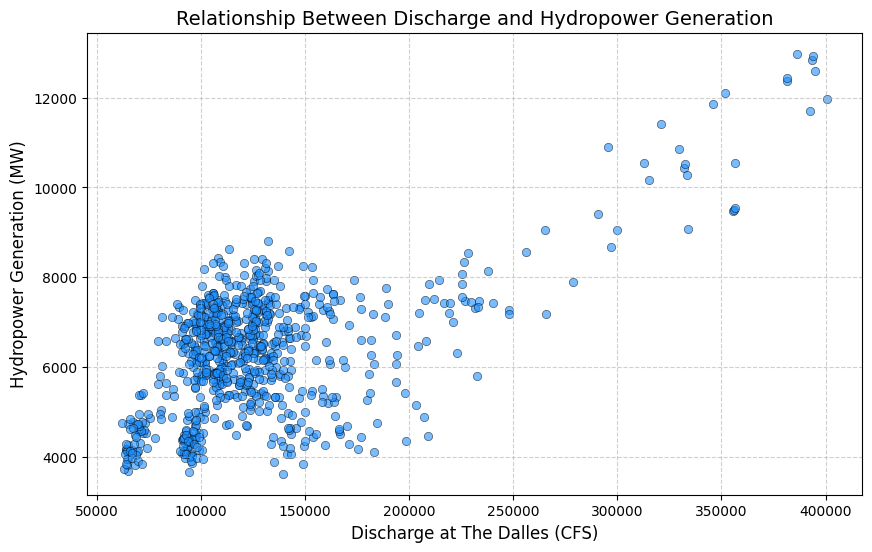

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Discharge_CFS'], df['Columbia_Projects_Hydro_Generation_MW'], 
            color="dodgerblue", alpha=0.6, edgecolors="black", linewidth=0.5)

plt.xlabel("Discharge at The Dalles (CFS)", fontsize=12)
plt.ylabel("Hydropower Generation (MW)", fontsize=12)
plt.title("Relationship Between Discharge and Hydropower Generation", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

<Axes: >

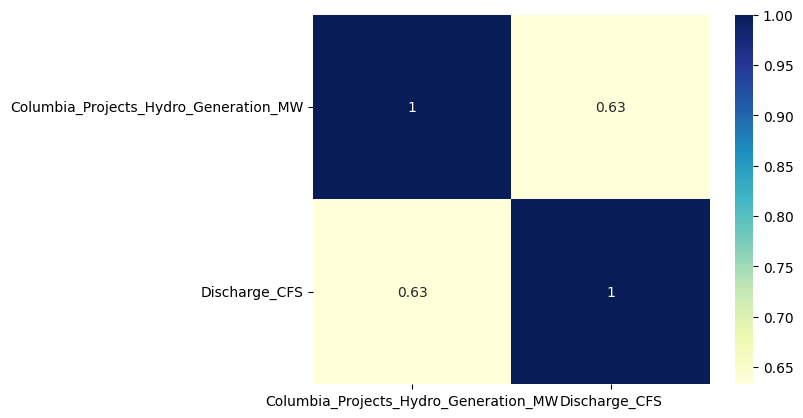

In [15]:
sns.heatmap(df[['Columbia_Projects_Hydro_Generation_MW', 'Discharge_CFS']].corr(), cmap="YlGnBu", annot=True)

## **Train-Test Split**

We use 80% of the data for training and reserve 20% for testing. This ensures the model learns from past trends and is evaluated on unseen data.

In [16]:
train_size = int(len(df) * 0.8)
test_size = int(len(df) * 0.2)
train, test = df.iloc[:train_size], df.iloc[train_size:]

## **Training Model**

The model learns the best-fit line using Ordinary Least Squares (OLS) and finds the optimal slope and intercept to minimize the error.

In [17]:
model = LinearRegression()
model.fit(train['Discharge_CFS'].values.reshape(-1, 1), train['Columbia_Projects_Hydro_Generation_MW'].values.reshape(-1, 1))

LinearRegression()

## **Forecasting on Test Data**


In [18]:
future_predictions = model.predict(test['Discharge_CFS'].values.reshape(-1, 1))

/var/folders/9x/c8rnngl93m162n92399m4b6w0000gn/T/ipykernel_63127/3458308183.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = future_predictions


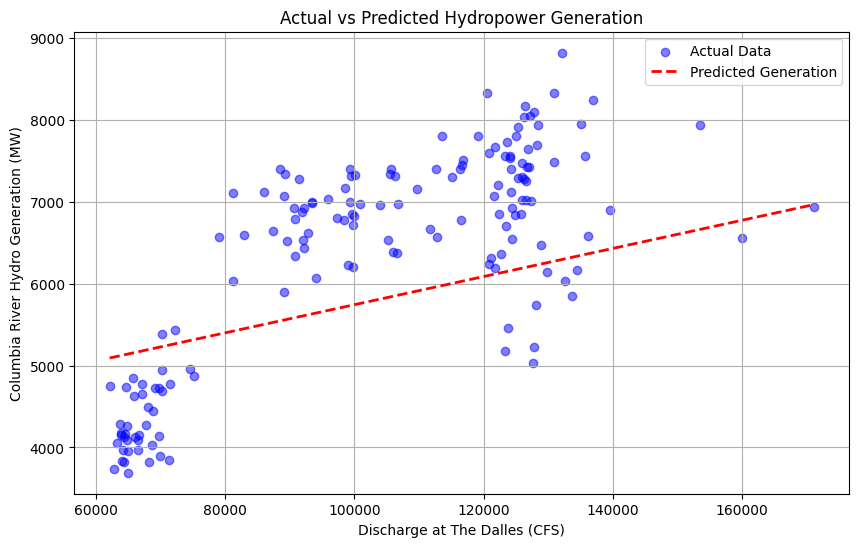

In [19]:
test['Predictions'] = future_predictions
test_sorted = test.sort_values(by="Discharge_CFS")

# Plot graph
plt.figure(figsize=(10, 6))

# Scatter plot for actual data
plt.scatter(test['Discharge_CFS'], test['Columbia_Projects_Hydro_Generation_MW'], 
            color="blue", alpha=0.5, label="Actual Data")

# Line plot for predictions
plt.plot(test_sorted['Discharge_CFS'], test_sorted['Predictions'], 
         color="red", linestyle="dashed", linewidth=2, label="Predicted Generation")

plt.xlabel("Discharge at The Dalles (CFS)")
plt.ylabel("Columbia River Hydro Generation (MW)")
plt.title("Actual vs Predicted Hydropower Generation")
plt.legend()
plt.grid(True)
plt.show()


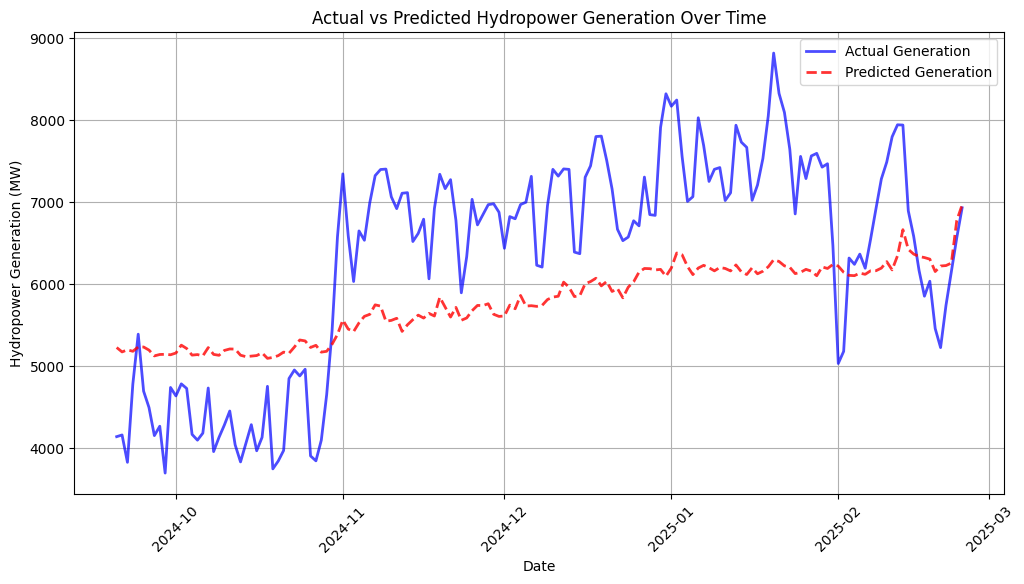

In [20]:
#  Create the plot
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(test.index, test['Columbia_Projects_Hydro_Generation_MW'], 
         color="blue", label="Actual Generation", linewidth=2, alpha=0.7)

# Plot predictions
plt.plot(test.index, test['Predictions'], 
         color="red", linestyle="dashed", linewidth=2, alpha=0.8, label="Predicted Generation")

plt.xlabel("Date")
plt.ylabel("Hydropower Generation (MW)")
plt.title("Actual vs Predicted Hydropower Generation Over Time")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.show()

## **Performance Evaluation**

- The model captures basic trends but fails during extreme seasonal fluctuations.
- While Linear Regression serves as a strong baseline, it struggles with complex hydropower generation patterns. Future models should consider lag features, external influences, and non-linearity for improved predictions.
- Linear Regression does not fully capture this relationship due to the spread of points at lower discharge values.
- Linear regression cannot predict future values directly like a VAR model using lagged values. If you want to predict Generation_MW, you need future Discharge_CFS values first.

In [21]:
score = np.sqrt(mean_squared_error(test['Columbia_Projects_Hydro_Generation_MW'], test['Predictions']))
mae = mean_absolute_error(test['Columbia_Projects_Hydro_Generation_MW'], test['Predictions'])
print(f"RMSE Score on the test set: {score:0.2f}")
print(f"Mean Absolute Error on the test set: {mae:0.2f}")

RMSE Score on the test set: 1154.83
Mean Absolute Error on the test set: 1040.68
